# 动漫风格迁移之AnimeGAN2

动漫是我们日常生活中常见的艺术形式，被广泛应用于广告、电影和儿童教育等多个领域。目前，动漫的制作主要是依靠手工实现。然而，手工制作动漫非常费力，需要非常专业的艺术技巧。对于动漫艺术家来说，创作高质量的动漫作品需要仔细考虑线条、纹理、颜色和阴影，这意味着创作动漫既困难又耗时。因此，能够将真实世界的照片自动转换为高质量动漫风格图像的自动技术是非常有价值的。它不仅能让艺术家们更多专注于创造性的工作，也能让普通人更容易创建自己的动漫作品。

## 模型简介

AnimeGAN是来自武汉大学和湖北工业大学的一项研究，采用的是神经风格迁移 + 生成对抗网络（GAN）的组合。该项目可以实现将真实图像动漫化，由Jie Chen等人在论文*AnimeGAN: A Novel Lightweight GAN for Photo Animation*中提出。生成器为对称编解码结构，主要由标准卷积、深度可分离卷积、反向残差块(IRB)、上采样和下采样模块组成。判别器由标准卷积组成。

## 网络特点

相比AnimeGAN，改进方向主要在以下4点：

1. 解决了生成的图像中的高频伪影问题。

2. 它易于训练，并能直接达到论文所述的效果。

3. 进一步减少生成器网络的参数数量。(现在生成器大小 8.07Mb)

4. 尽可能多地使用来自BD电影的高质量风格数据。

## 数据处理

开始实验之前，请确保本地已经安装了Python环境并安装了MindSpore Vision套件。

### 数据准备

数据集包含6656张真实的风景图片，3种动漫风格:Hayao，Shinkai，Paprika，每一种动漫风格都是从对应的电影中通过对视频帧的随机裁剪生成的，除此之外数据集中也包含用于测试的各种尺寸大小的图像。数据集信息如下图所示：  
![](images/dataset_information.jpg)
数据集图片如下图所示：  
![](images/dataset.jpg)
[数据集下载](https://github.com/TachibanaYoshino/AnimeGAN/releases/download/dataset-1/dataset.zip)
解压后的数据集目录结构如下：

```text

.dataset/
    ├── Hayao
             ├──smooth
             └──style
    ├── Shinkai
              ├──smooth
              └──style
    ├── Shinkai
              ├──smooth
              └──style
    ├── train_photo
              ├──0.jpg
              ├──1.jpg
              ......
              └──2017-01-03 09_45_13.jpg
```

本模型使用vgg19网络用于图像特征提取和损失函数的计算，因此需要加载预训练的网络模型参数。  
[vgg19预训练模型下载](https://pan.baidu.com/s/1snIQUxD5XpQZZflhESJOIg?pwd=u6hc)  
下载完成后将vgg.ckpt文件放在和本文件同级的目录下。

### 数据预处理

由于在计算损失函数时需要用到动漫图像的边缘平滑图像，在上面提到的数据集中已经包含了平滑后的图像，如果自己创建动漫数据集可通过下面的代码生成边缘平滑图像。

In [1]:
from src.utils.edge_smooth import make_edge_smooth


# 动漫图像目录
style_dir = '/home/nc438/ztf/animeganv2/dataset/Sakura/style'

# 输出图像目录
output_dir = '/home/nc438/ztf/animeganv2/dataset/Sakura/smooth'

# 输出图像大小
size = 256

#平滑图像，输出结果在smooth文件夹下
make_edge_smooth(style_dir, output_dir, size)

100%|██████████| 6/6 [00:00<00:00, 10.74it/s]


### 训练集可视化


Mean(B, G, R) of Hayao are [-4.4346958  -8.66591597 13.10061177]
Dataset: real 6656 style 1792, smooth 1792


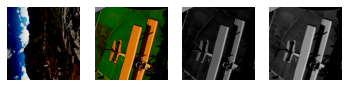

In [19]:
import argparse
import matplotlib.pyplot as plt
from src.process_datasets.animeganv2_dataset import AnimeGANDataset
import numpy as np


# 加载参数
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='Hayao', choices=['Hayao', 'Shinkai', 'Paprika'], type=str)
parser.add_argument('--data_dir', default='./dataset', type=str)
parser.add_argument('--batch_size', default=4, type=int)
parser.add_argument('--debug_samples', default=0, type=int)
parser.add_argument('--num_parallel_workers', default=1, type=int)
args = parser.parse_args(args=[])
plt.figure()

# 加载数据集
data = AnimeGANDataset(args)
data = data.run()
iter = next(data.create_tuple_iterator())

# 循环处理
for i in range(1, 5):
    plt.subplot(1, 4, i)
    temp = np.clip(iter[i - 1][0].asnumpy().transpose(2, 1, 0), 0, 1)
    plt.imshow(temp)
    plt.axis("off")


## 构建网络

处理完数据后进行网络的搭建。按照AnimeGAN论文中的描述，所有模型权重均应按照mean为0，sigma为0.02的正态分布随机初始化。

### 生成器

生成器G的功能是将内容图片转化为具有卡通风格的风格图片。在实践场景中，该功能是通过卷积、深度可分离卷积、反向残差块、上采样和下采样模块来完成。网络结构如下图所示：
![](./images/generator.jpg)

其中小模块结构如下：
![](./images/blocks.jpg)

In [3]:
import os
import mindspore.nn as nn

from src.models.upsample import UpSample
from src.models.conv2d_block import ConvBlock
from src.models.inverted_residual_block import InvertedResBlock


class Generator(nn.Cell):
    """AnimeGAN网络生成器"""
    def __init__(self):
        super(Generator, self).__init__()
        has_bias = False

        self.generator = nn.SequentialCell()
        self.generator.append(ConvBlock(3, 32, kernel_size=7))
        self.generator.append(ConvBlock(32, 64, stride=2))
        self.generator.append(ConvBlock(64, 128, stride=2))
        self.generator.append(ConvBlock(128, 128))
        self.generator.append(ConvBlock(128, 128))

        self.generator.append(InvertedResBlock(128, 256))
        self.generator.append(InvertedResBlock(256, 256))
        self.generator.append(InvertedResBlock(256, 256))
        self.generator.append(InvertedResBlock(256, 256))
        self.generator.append(ConvBlock(256, 128))

        self.generator.append(UpSample(128, 128))
        self.generator.append(ConvBlock(128, 128))

        self.generator.append(UpSample(128, 64))
        self.generator.append(ConvBlock(64, 64))
        self.generator.append(ConvBlock(64, 32, kernel_size=7))
        self.generator.append(
            nn.Conv2d(32, 3, kernel_size=1, stride=1, pad_mode='same', padding=0,
                      weight_init=Normal(mean=0, sigma=0.02), has_bias=has_bias))
        self.generator.append(nn.Tanh())

    def construct(self, x):
        out1 = self.generator(x)
        return out1


### 判别器

判别器D是一个二分类网络模型，输出判定该图像为真实图的概率。通过一些列的Conv2d、LeakyRelu和InstanceNorm层对其进行处理，最后通过一个Conv2d层得到最终的概率。

In [4]:
import mindspore.nn as nn

from mindspore.common.initializer import Normal


class Discriminator(nn.Cell):
    """AnimeGAN网络判别器"""
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.name = f'discriminator_{args.dataset}'
        self.has_bias = False

        channels = args.ch // 2

        layers = [
            nn.Conv2d(3, channels, kernel_size=3, stride=1, pad_mode='same', padding=0,
                      weight_init=Normal(mean=0, sigma=0.02), has_bias=self.has_bias),
            nn.LeakyReLU(alpha=0.2)
        ]

        for _ in range(1, args.n_dis):
            layers += [
                nn.Conv2d(channels, channels * 2, kernel_size=3, stride=2, pad_mode='same', padding=0,
                          weight_init=Normal(mean=0, sigma=0.02), has_bias=self.has_bias),
                nn.LeakyReLU(alpha=0.2),
                nn.Conv2d(channels * 2, channels * 4, kernel_size=3, stride=1, pad_mode='same', padding=0,
                          weight_init=Normal(mean=0, sigma=0.02), has_bias=self.has_bias),
                nn.InstanceNorm2d(channels * 4, affine=False),
                nn.LeakyReLU(alpha=0.2),
            ]
            channels *= 4

        layers += [
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, pad_mode='same', padding=0,
                      weight_init=Normal(mean=0, sigma=0.02), has_bias=self.has_bias),
            nn.InstanceNorm2d(channels, affine=False),
            nn.LeakyReLU(alpha=0.2),
            nn.Conv2d(channels, 1, kernel_size=3, stride=1, pad_mode='same', padding=0,
                      weight_init=Normal(mean=0, sigma=0.02), has_bias=self.has_bias),
        ]

        self.discriminate = nn.SequentialCell(layers)

    def construct(self, x):
        return self.discriminate(x)


## 损失函数

损失函数主要分为对抗损失、内容损失、灰度风格损失、颜色重建损失四个部分，不同的损失有不同的权重系数，整体的损失函数表示为：

  $$L(G,D) = \omega_{adv}L_{adv}(G,D) + \omega_{con}L_{con}(G,D) + \omega_{gra}L_{gra}(G,D) + \omega_{col}L_{col}(G,D) \tag{1}$$

其中$L_{adv}(G,D)$表示对抗损失，是生成器G中影响动画转换过程的对抗性损失，$L_{con}(G,D)$表示内容损失，是帮助生成的图像保留输入照片内容的内容损失，$L_{gra}(G,D)$表示灰度风格损失，使生成的图像在纹理和线条上具有清晰的动漫风格，$L_{col}(G,D)$表示颜色重建损失，使生成的图像具有原照片的颜色。$\omega_{adv}$，$\omega_{con}$，$\omega_{gra}$，$\omega_{col}$分别表示四个损失的权重，我们将其分别设置为$300，1.5，3，10$。

对于内容损失和灰度风格损失，使用预先训练好的VGG19作为感知网络，提取图像的高级语义特征，可表示为：

  $$L_{con}(G,D) = E_{pi\sim S_{data}(p)}\lbrack\left| \left| {VGG}_{l}\left( p_{i} \right) - {VGG}_{l}\left( G\left( p_{i} \right) \right) \right| \right|_{1}\rbrack \tag{2}$$

  $$L_{gra}(G,D) = E_{p_{i}\sim S_{data}(p)},E_{x_{i}\sim S_{data}(x)}\lbrack\left| \left| {Gram(VGG}_{l}\left( G\left( p_{i} \right) \right)) - {Gram(VGG}_{l}\left( p_{i} \right)) \right| \right|_{1}\rbrack \tag{3}$$

公式1、2中，${VGG}_{l}(﹒)$表示VGG网络中第*l*层的特征图，$﹒$表示输入。我们使用VGG网络中的conv4_4作为第*l*层的输出。Gram表示特征图的Gram矩阵。$G\left( p_{i} \right)$表示生成器生成的图像，$p_{i}$表示输入的内容图。我们使用$L_{1}$损失来计算内容损失和灰度风格损失。

关于颜色的提取和转换，首先将RGB通道转换为YUV通道，然后对不同通道使用不同的损失计算方法。颜色重建损失表示为：

  $$L_{col}(G,D) = E_{pi\sim S_{data}(p)}\lbrack\left| \left| Y\left( G\left( p_{i} \right) \right) - Y\left( p_{i} \right) \right| \right|_{1} + \left| \left| U\left( G\left( p_{i} \right) \right) - U\left( p_{i} \right) \right| \right|_{H} + \left| \left| V\left( G\left( p_{i} \right) \right) - V\left( p_{i} \right) \right| \right|_{H}\rbrack \tag{4}$$

公式3中，$Y\left( p_{i} \right)$，$U\left( p_{i} \right)$，$V\left( p_{i} \right)$分别表示图像$p_{i}$的YUV三个通道，*H*表示Huber损失。

最终的生成器损失$L(G)$可以表示为：

  $$L(G) = \omega_{adv}E_{pi\sim S_{data}(p)}\left\lbrack \left( G\left( p_{i} \right) - 1 \right)^{2} \right\rbrack + \omega_{con}L_{con}(G,D) + \omega_{gra}L_{gra}(G,D) + \omega_{col}L_{col}(G,D) \tag{5}$$

判别器使用的损失函数，除了引入 CartoonGAN提出的促进边缘的对抗损失，使AnimeGAN生成的图像具有清晰的重现边缘外，还采用了一种新型的灰度对抗损失，防止生成的图像以灰度图像的形式显示。最后，判别器的损失函数表示为：  

  $$L(D) = \omega_{adv}\lbrack E_{ai\sim S_{data}(a)}\left\lbrack \left( D\left( a_{i} \right) - 1 \right)^{2} \right\rbrack + E_{pi\sim S_{data}(p)}\left\lbrack \left( D\left( G\left( p_{i} \right) \right) \right)^{2} \right\rbrack + E_{xi\sim S_{data}(x)}\left\lbrack \left( D\left( x_{i} \right) \right)^{2} \right\rbrack + 0.1E_{yi\sim S_{data}(y)}\lbrack\left( D\left( y_{i} \right) \right)^{2}\rbrack \tag{6}$$

公式6中，$E_{yi\sim S_{data}(y)}\lbrack\left( D\left( y_{i} \right) \right)^{2}\rbrack$表示边缘促进对抗性损失，$E_{xi\sim S_{data}(x)}\left\lbrack \left( D\left( x_{i} \right) \right)^{2} \right\rbrack$表示灰度对抗性损失，0.1是比例因子。将边缘促进对抗性损失的比例因子设置为0.1的目的是避免生成图像的边缘过于尖锐。

### 生成器损失


In [5]:
import mindspore

from src.losses.gram_loss import GramLoss
from src.losses.color_loss import ColorLoss
from src.models.vgg19 import Vgg


def vgg19(args, num_classes=1000):
    """加载预训练的vgg19模型参数"""

    # 构建网络
    net = Vgg([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512], num_classes=num_classes,
              batch_norm=True)

    # 加载模型
    param_dict = load_checkpoint(args.vgg19_path)
    load_param_into_net(net, param_dict)
    net.requires_grad = False
    return net


class GeneratorLoss(nn.Cell):
    """连接生成器和损失"""
    def __init__(self, discriminator, generator, args):
        super(GeneratorLoss, self).__init__(auto_prefix=True)
        self.discriminator = discriminator
        self.generator = generator
        self.content_loss = nn.L1Loss()
        self.gram_loss = GramLoss()
        self.color_loss = ColorLoss()
        self.wadvg = args.wadvg
        self.wadvd = args.wadvd
        self.wcon = args.wcon
        self.wgra = args.wgra
        self.wcol = args.wcol
        self.vgg19 = vgg19(args)
        self.adv_type = args.gan_loss
        self.bce_loss = nn.BCELoss()
        self.relu = nn.ReLU()
        self.adv_type = args.gan_loss

    def construct(self, img, anime_gray):
        """构建生成器损失计算结构"""
        fake_img = self.generator(img)
        fake_d = self.discriminator(fake_img)
        fake_feat = self.vgg19(fake_img)
        anime_feat = self.vgg19(anime_gray)
        img_feat = self.vgg19(img)
        result = self.wadvg * self.adv_loss_g(fake_d) + \
            self.wcon * self.content_loss(img_feat, fake_feat) + \
            self.wgra * self.gram_loss(anime_feat, fake_feat) + \
            self.wcol * self.color_loss(img, fake_img)
        return result

    def adv_loss_g(self, pred):
        """选择损失函数类型"""
        if self.adv_type == 'hinge':
            return -mindspore.numpy.mean(pred)

        if self.adv_type == 'lsgan':
            return mindspore.numpy.mean(mindspore.numpy.square(pred - 1.0))

        if self.adv_type == 'normal':
            return self.bce_loss(pred, mindspore.numpy.zeros_like(pred))

        return mindspore.numpy.mean(mindspore.numpy.square(pred - 1.0))

### 判别器损失


In [6]:
class DiscriminatorLoss(nn.Cell):
    """连接判别器和损失"""
    def __init__(self, discriminator, generator, args):
        nn.Cell.__init__(self, auto_prefix=True)
        self.discriminator = discriminator
        self.generator = generator
        self.content_loss = nn.L1Loss()
        self.gram_loss = nn.L1Loss()
        self.color_loss = ColorLoss()
        self.wadvg = args.wadvg
        self.wadvd = args.wadvd
        self.wcon = args.wcon
        self.wgra = args.wgra
        self.wcol = args.wcol
        self.vgg19 = vgg19(args)
        self.adv_type = args.gan_loss
        self.bce_loss = nn.BCELoss()
        self.relu = nn.ReLU()

    def construct(self, img, anime, anime_gray, anime_smt_gray):
        """构建判别器损失计算结构"""
        fake_img = self.generator(img)
        fake_d = self.discriminator(fake_img)
        real_anime_d = self.discriminator(anime)
        real_anime_gray_d = self.discriminator(anime_gray)
        real_anime_smt_gray_d = self.discriminator(anime_smt_gray)

        return self.wadvd * (
            1.7 * self.adv_loss_d_real(real_anime_d) +
            1.7 * self.adv_loss_d_fake(fake_d) +
            1.7 * self.adv_loss_d_fake(real_anime_gray_d) +
            1.0 * self.adv_loss_d_fake(real_anime_smt_gray_d)
        )

    def adv_loss_d_real(self, pred):
        """真实动漫图像的判别损失类型"""
        if self.adv_type == 'hinge':
            return mindspore.numpy.mean(self.relu(1.0 - pred))

        if self.adv_type == 'lsgan':
            return mindspore.numpy.mean(mindspore.numpy.square(pred - 1.0))

        if self.adv_type == 'normal':
            return self.bce_loss(pred, mindspore.numpy.ones_like(pred))

        return mindspore.numpy.mean(mindspore.numpy.square(pred - 1.0))

    def adv_loss_d_fake(self, pred):
        """生成动漫图像的判别损失类型"""
        if self.adv_type == 'hinge':
            return mindspore.numpy.mean(self.relu(1.0 + pred))

        if self.adv_type == 'lsgan':
            return mindspore.numpy.mean(mindspore.numpy.square(pred))

        if self.adv_type == 'normal':
            return self.bce_loss(pred, mindspore.numpy.zeros_like(pred))

        return mindspore.numpy.mean(mindspore.numpy.square(pred))

## 模型实现

由于GAN网络结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。MindSpore要求将损失函数、优化器等操作也看做nn.Cell的子类，所以我们可以自定义AnimeGAN类，将网络和loss连接起来。

In [7]:
class AnimeGAN(nn.Cell):
    """定义AnimeGAN网络"""
    def __init__(self, my_train_one_step_cell_for_d, my_train_one_step_cell_for_g):
        super(AnimeGAN, self).__init__(auto_prefix=True)
        self.my_train_one_step_cell_for_g = my_train_one_step_cell_for_g
        self.my_train_one_step_cell_for_d = my_train_one_step_cell_for_d

    def construct(self, img, anime, anime_gray, anime_smt_gray):
        output_d_loss = self.my_train_one_step_cell_for_d(img, anime, anime_gray, anime_smt_gray)
        output_g_loss = self.my_train_one_step_cell_for_g(img, anime_gray)
        return output_d_loss, output_g_loss

### 模型训练

训练分为两个部分：训练判别器和训练生成器。训练判别器的目的是最大程度地提高判别图像真伪的概率。训练生成器可以生成更好的虚假动漫图像。两者通过最小化损失函数可达到最优。

In [ ]:
import argparse
import os
import cv2
import numpy as np
import mindspore
from mindspore import Tensor
from mindspore import float32 as dtype
from mindspore import nn
from mindspore import context
from tqdm import tqdm

from src.models.generator import Generator
from src.models.discriminator import Discriminator
from src.models.animegan import AnimeGAN
from src.utils.pre_process import denormalize_input
from src.losses.loss import GeneratorLoss, DiscriminatorLoss
from src.process_datasets.animeganv2_dataset import AnimeGANDataset


# 加载参数
parser = argparse.ArgumentParser(description='train')
parser.add_argument('--device_target', default='GPU', choices=['CPU', 'GPU', 'Ascend'], type=str)
parser.add_argument('--device_id', default=1, type=int)
parser.add_argument('--dataset', default='Hayao', choices=['Hayao', 'Shinkai', 'Paprika'], type=str)
parser.add_argument('--data_dir', default='./dataset', type=str)
parser.add_argument('--checkpoint_dir', default='./checkpoints', type=str)
parser.add_argument('--vgg19_path', default='./vgg.ckpt', type=str)
parser.add_argument('--save_image_dir', default='./images', type=str)
parser.add_argument('--resume', default=False, type=bool)
parser.add_argument('--phase', default='train', type=str)
parser.add_argument('--epochs', default=1, type=int)
parser.add_argument('--init_epochs', default=5, type=int)
parser.add_argument('--batch_size', default=16, type=int)
parser.add_argument('--num_parallel_workers', default=1, type=int)
parser.add_argument('--save_interval', default=1, type=int)
parser.add_argument('--debug_samples', default=0, type=int)
parser.add_argument('--lr_g', default=2.0e-4, type=float)
parser.add_argument('--lr_d', default=4.0e-4, type=float)
parser.add_argument('--init_lr', default=1.0e-3, type=float)
parser.add_argument('--gan_loss', default='lsgan', choices=['lsgan', 'hinge', 'bce'], type=str)
parser.add_argument('--wadvg', default=1.7, type=float, help='Adversarial loss weight for G')
parser.add_argument('--wadvd', default=300, type=float, help='Adversarial loss weight for D')
parser.add_argument('--wcon', default=1.8, type=float, help='Content loss weight')
parser.add_argument('--wgra', default=3.0, type=float, help='Gram loss weight')
parser.add_argument('--wcol', default=10.0, type=float, help='Color loss weight')
parser.add_argument('--img_ch', default=3, type=int, help='The size of image channel')
parser.add_argument('--ch', default=64, type=int, help='Base channel number per layer')
parser.add_argument('--n_dis', default=3, type=int, help='The number of discriminator layer')
args = parser.parse_args(args=[])
if context.get_context('device_id') != args.device_id:
    context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target, device_id=args.device_id)

# 实例化生成器和判别器
generator = Generator()
discriminator = Discriminator(args)

# 设置两个单独的优化器，一个用于D，另一个用于G。
optimizer_g = nn.Adam(generator.trainable_params(), learning_rate=args.lr_g, beta1=0.5, beta2=0.999)
optimizer_d = nn.Adam(discriminator.trainable_params(), learning_rate=args.lr_d, beta1=0.5, beta2=0.999)

# 实例化WithLossCell
net_d_with_criterion = DiscriminatorLoss(discriminator, generator, args)
net_g_with_criterion = GeneratorLoss(discriminator, generator, args)

# 实例化TrainOneStepCell
my_train_one_step_cell_for_d = nn.TrainOneStepCell(net_d_with_criterion, optimizer_d)
my_train_one_step_cell_for_g = nn.TrainOneStepCell(net_g_with_criterion, optimizer_g)
animegan = AnimeGAN(my_train_one_step_cell_for_d, my_train_one_step_cell_for_g)
animegan.set_train()

# 加载数据集
data = AnimeGANDataset(args)
data = data.run()
size = data.get_dataset_size()
for epoch in range(args.epochs):
    iters = 0

    # 为每轮训练读入数据
    for img, anime, anime_gray, anime_smt_gray in tqdm(data.create_tuple_iterator()):
        img = Tensor(img, dtype=dtype)
        anime = Tensor(anime, dtype=dtype)
        anime_gray = Tensor(anime_gray, dtype=dtype)
        anime_smt_gray = Tensor(anime_smt_gray, dtype=dtype)
        net_d_loss, net_g_loss = animegan(img, anime, anime_gray, anime_smt_gray)
        if iters % 50 == 0:

            # 输出训练记录
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (
                epoch + 1, args.epochs, iters, size, net_d_loss.asnumpy().min(), net_g_loss.asnumpy().min()))

        # 每个epoch结束后，使用生成器生成一组图片
        if (epoch % args.save_interval) == 0 and (iters == size - 1):
            stylized = denormalize_input(generator(img)).asnumpy()
            no_stylized = denormalize_input(img).asnumpy()
            imgs = cv2.cvtColor(stylized[0, :, :, :].transpose(1, 2, 0), cv2.COLOR_RGB2BGR)
            imgs1 = cv2.cvtColor(no_stylized[0, :, :, :].transpose(1, 2, 0), cv2.COLOR_RGB2BGR)
            for i in range(1, args.batch_size):
                imgs = np.concatenate(
                    (imgs, cv2.cvtColor(stylized[i, :, :, :].transpose(1, 2, 0), cv2.COLOR_RGB2BGR)), axis=1)
                imgs1 = np.concatenate(
                    (imgs1, cv2.cvtColor(no_stylized[i, :, :, :].transpose(1, 2, 0), cv2.COLOR_RGB2BGR)), axis=1)
            cv2.imwrite(
                os.path.join(args.save_image_dir, args.dataset, 'epoch_' + str(epoch) + '.jpg'),
                np.concatenate((imgs1, imgs), axis=0))

            # 保存网络模型参数为ckpt文件
            mindspore.save_checkpoint(generator, os.path.join(args.checkpoint_dir, args.dataset,
                                                              'netG_' + str(epoch) + '.ckpt'))
        iters += 1

[WARNING] ME(4871:126107299219264,MainProcess):2022-07-11-20:54:46.956.2 [mindspore/run_check/_check_version.py:140] MindSpore version 1.7.0 and cuda version 11.6.55 does not match, please refer to the installation guide for version matching information: https://www.mindspore.cn/install


Mean(B, G, R) of Hayao are [-4.4346958  -8.66591597 13.10061177]
Dataset: real 6656 style 1792, smooth 1792


0it [00:00, ?it/s][WARNING] KERNEL(4871,72b1a4c60740,python):2022-07-11-20:55:00.494.404 [mindspore/ccsrc/plugin/device/gpu/kernel/cuda_impl/cuda_class/cuda_class_common.h:55] CalShapesSizeInBytes] For 'Abs', the shapes[0] is ( )
[WARNING] KERNEL(4871,72b1a4c60740,python):2022-07-11-20:55:00.494.466 [mindspore/ccsrc/plugin/device/gpu/kernel/cuda_impl/cuda_class/cuda_class_common.h:55] CalShapesSizeInBytes] For 'Neg', the shapes[0] is ( )
1it [00:05,  5.89s/it]

[1/1][0/416]	Loss_D: 2268.1411	Loss_G: 25.8909


13it [00:14,  1.37it/s]

![batch_size=4, epoch=26时的训练结果](./images/epoch_26_1663.jpg)

## 模型推理

运行下面代码，将一张真实风景图像输入到网络中，即可生成动漫化的图像。

In [ ]:
import argparse
import os

import cv2
from mindspore import Tensor
from mindspore import context
from mindspore import float32 as dtype
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train.model import Model
from tqdm import tqdm

from src.models.generator import Generator
from src.utils.pre_process import transform, inverse_transform_infer


# 加载参数
parser = argparse.ArgumentParser(description='infer')
parser.add_argument('--device_target', default='GPU', choices=['CPU', 'GPU', 'Ascend'], type=str)
parser.add_argument('--device_id', default=1, type=int)
parser.add_argument('--infer_dir', default='./dataset/infer', type=str)
parser.add_argument('--infer_output', default='./dataset/output', type=str)
parser.add_argument('--ckpt_file_name', default='./checkpoints/Hayao/netG_16.ckpt', type=str)
args = parser.parse_args(args=[])
if context.get_context('device_id') != args.device_id:
    context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target, device_id=args.device_id)

# 实例化生成器
net = Generator()

# 从文件中获取模型参数并加载到网络中
param_dict = load_checkpoint(args.ckpt_file_name)
load_param_into_net(net, param_dict)
data = os.listdir(args.infer_dir)
bar = tqdm(data)
model = Model(net)

if not os.path.exists(args.infer_output):
    os.mkdir(args.infer_output)

# 循环读取和处理图像
for img_path in bar:
    img = transform(os.path.join(args.infer_dir, img_path))
    img = Tensor(img, dtype=dtype)
    output = model.predict(img)
    img = inverse_transform_infer(img)
    output = inverse_transform_infer(output)
    output = cv2.resize(output, (img.shape[1], img.shape[0]))

    # 保存生成的图像
    cv2.imwrite(os.path.join(args.infer_output, img_path), output)
print('Successfully output images in ' + args.infer_output)

各风格模型推理结果:  
![推理结果对比](./images/infer.jpg)

## 视频处理

下面的方法输入视频文件的格式为mp4，视频处理完之后声音不会被保留。

In [ ]:
import argparse

import cv2
from mindspore import Tensor
from mindspore import context
from mindspore import float32 as dtype
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train.model import Model
from tqdm import tqdm

from src.models.generator import Generator
from src.utils.adjust_brightness import adjust_brightness_from_src_to_dst
from src.utils.pre_process import preprocessing, convert_image, inverse_image


# 加载参数，video_input和video_output设置输入输出视频路径，video_ckpt_file_name选择推理模型
parser = argparse.ArgumentParser(description='video2anime')
parser.add_argument('--device_target', default='GPU', choices=['CPU', 'GPU', 'Ascend'], type=str)
parser.add_argument('--device_id', default=1, type=int)
parser.add_argument('--video_ckpt_file_name', default='./checkpoints/Hayao/netG_16.ckpt', type=str)
parser.add_argument('--video_input', default='./video/test.mp4', type=str)
parser.add_argument('--video_output', default='./video/output.mp4', type=str)
parser.add_argument('--output_format', default='mp4v', type=str)
parser.add_argument('--img_size', default=[256, 256], type=list, help='The size of image: H and W')
args = parser.parse_args(args=[])
if context.get_context('device_id') != args.device_id:
    context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target, device_id=args.device_id)

# 实例化生成器
net = Generator()
param_dict = load_checkpoint(args.video_ckpt_file_name)

# 读取视频文件
vid = cv2.VideoCapture(args.video_input)
total = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(vid.get(cv2.CAP_PROP_FPS))
codec = cv2.VideoWriter_fourcc(*args.output_format)

# 从文件中获取模型参数并加载到网络中
load_param_into_net(net, param_dict)
model = Model(net)
ret, img = vid.read()

img = preprocessing(img, args.img_size)
height, width = img.shape[:2]

# 设置输出视频的分辨率
out = cv2.VideoWriter(args.video_output, codec, fps, (width, height))
pbar = tqdm(total=total)
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

# 处理视频帧
while ret:
    ret, frame = vid.read()
    if frame is None:
        print('Warning: got empty frame.')
        continue
    img = convert_image(frame, args.img_size)
    img = Tensor(img, dtype=dtype)
    fake_img = model.predict(img).asnumpy()
    fake_img = inverse_image(fake_img)
    fake_img = adjust_brightness_from_src_to_dst(fake_img, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # 保存视频文件
    out.write(cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB))
    pbar.update(1)

pbar.close()
vid.release()

## 算法流程

![](./images/flowchart.jpg)

## 总结

本案例对AnimeGAN的论文中提出的模型进行了详细的解释，向读者完整地展现了该算法的流程，分析了AnimeGAN在动漫风格迁移方面的优势和存在的不足。如需查看详细代码，可参考MindSpore Vision套件。

## 引用

[1] Gatys, L. A., Ecker, A. S., & Bethge, M. (2016). Image style transfer using convolutional neural networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2414-2423).  
[2] Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). Perceptual losses for real-time style transfer and super-resolution. In European conference on computer vision (pp. 694-711). Springer, Cham.  
[3] Li, Y., Fang, C., Yang, J., Wang, Z., Lu, X., & Yang, M. H. (2017). Diversified texture synthesis with feed-forward networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 3920-3928).  
[4] Chen, Y., Lai, Y. K., & Liu, Y. J. (2018). Cartoongan: Generative adversarial networks for photo cartoonization. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 9465-9474).  
[5] Li, Y., Liu, M. Y., Li, X., Yang, M. H., & Kautz, J. (2018). A closed-form solution to photorealistic image stylization. In Proceedings of the European Conference on Computer Vision (ECCV) (pp. 453-468).  